### The following section includes sourced code to generate a graph coloring problem.

In [1]:
################################################################
##
## GRAPH COLORING PROBLEM GENERATOR
##
## Generates a planar graph.
##
################################################################

import random

class Point:
    ID_COUNT = 0
    def __init__(self, x, y):
        self.id = Point.ID_COUNT
        Point.ID_COUNT += 1
        self.x = x
        self.y = y

    def transform(self, xt, yt):
        return (xt(self.x), yt(self.y))

    def dist(self, them):
        return abs(self.x - them.x) + abs(self.y - them.y)

    def __repr__(self):
        return "p({:.4f}, {:.4f})".format(self.x, self.y)

## From http://bryceboe.com/2006/10/23/line-segment-intersection-algorithm/
def _ccw(A,B,C):
    return (C.y-A.y)*(B.x-A.x) > (B.y-A.y)*(C.x-A.x)

class Line:
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2

    @property
    def endpoints(self):
        return [self.p1, self.p2]

    def transform(self, xt = lambda x: x, yt = lambda y: y):
        start = self.p1.transform(xt, yt)
        end = self.p2.transform(xt, yt)
        return (start, end)

    def intersects(self, them):
        A = self.p1
        B = self.p2
        C = them.p1
        D = them.p2
        return _ccw(A,C,D) != _ccw(B,C,D) and _ccw(A,B,C) != _ccw(A,B,D)

    def __repr__(self):
        return "[{} -> {}]".format(self.p1, self.p2)

def _random_point():
    return Point(random.uniform(-10, 10), random.uniform(-10, 10))

def _find_line(x, lines, pairs):
    for i, x1 in enumerate(x[:-1]):
        shortest_items = sorted([(x2, x1.dist(x2)) for x2 in x[i+1:]], key=lambda item: item[1])
        for x2, _ in shortest_items:
            l1 = Line(x1, x2)
            if not (x1, x2) in pairs and not _line_intersects(l1, lines):
                return l1
    return None

def _line_intersects(l1, lines):
    for l2 in lines:
        if l1.p1 in l2.endpoints or l1.p2 in l2.endpoints:
            continue
        if l1.intersects(l2): return True
    return False

def gen(num_points=100):
    x = [_random_point() for _ in range(num_points)]
    lines = set([])
    pairs = set([])
    while True:
        random.shuffle(x)
        line = _find_line(x, lines, pairs)
        if line:
            pairs.add((line.p1, line.p2))
            lines.add(line)
        else:
            break
    return (x, lines)

In [2]:
import json

num_points = 100
output_file = "gcp.json"

print("Generating a planar graph with {} points...".format(num_points))
(x, lines) = gen(num_points=num_points)

print("Writing to '{}'...".format(output_file))
with open(output_file, 'w') as f:
    f.write(json.dumps({
        'num_points': len(x),
        'points': { p.id: (p.x, p.y) for p in x },
        'edges': [ (line.p1.id, line.p2.id) for line in lines ]
    }, indent=2))
print("""Done! You can now import the results into a Python script with the code:

import json

with open('{}', \'r\') as f:
    data = json.load(f)
""".format(output_file))

Generating a planar graph with 100 points...
Writing to 'gcp.json'...
Done! You can now import the results into a Python script with the code:

import json

with open('gcp.json', 'r') as f:
    data = json.load(f)



In [3]:
import json

with open('gcp.json', 'r') as f:
    data = json.load(f)
    print(data)

{'num_points': 100, 'points': {'97': [-2.19221420825537, -8.495409939284432], '57': [6.819185522930752, -8.73928372182859], '72': [-7.829390490734696, -3.970834429728649], '41': [8.700979543374881, 1.3788525853902591], '74': [-1.883281932637166, 1.8133675932347728], '71': [8.644524482483309, -7.023737079040315], '31': [-6.6368386697934305, -1.304792097365704], '66': [0.9995394698577869, -1.4869733550412239], '0': [-2.7878426194115935, -6.831573900318562], '53': [1.1957174746710386, -4.872801623272823], '2': [-8.61149061223378, -9.002695459154964], '30': [6.595983566711588, -9.682027585687331], '47': [-9.563973505944467, 8.762724186935834], '89': [3.344645679578198, -2.481098596867115], '9': [-6.123101233256989, 1.8312859551158684], '91': [9.1741740069406, 5.661556195409254], '80': [3.2205841740277172, -9.945326807254325], '70': [-8.505305866549886, 3.311563281328212], '27': [5.885715533589984, -2.856677704764743], '34': [-8.205880460558955, -8.370757123786321], '83': [-1.89109677424658

### The following section includes sourced code to generate a Sudoku problem.

In [4]:
################################################################
## CLI Wrapper for a Sudoku generator
##  by Chad Crawford, using code from Gareth Rees
################################################################

import random
from functools import *

## From Gareth Rees at https://codereview.stackexchange.com/a/88866
def make_board(m: int=3) -> list[list[int]]:
    """Return a random filled m**2 x m**2 Sudoku board."""
    n = m**2
    board = [[None for _ in range(n)] for _ in range(n)]

    def search(c: int=0) -> list[list[int]]:
        "Recursively search for a solution starting at position c."
        i, j = divmod(c, n)
        i0, j0 = i - i % m, j - j % m # Origin of mxm block
        numbers = list(range(1, n + 1))
        random.shuffle(numbers)
        for x in numbers:
            if (x not in board[i]                     # row
                and all(row[j] != x for row in board) # column
                and all(x not in row[j0:j0+m]         # block
                        for row in board[i0:i])):
                board[i][j] = x
                if c + 1 >= n**2 or search(c + 1):
                    return board
        else:
            # No number is valid in this cell: backtrack and try again.
            board[i][j] = None
            return None

    return search()

In [5]:
import json

def write_board(cell_length: int, num_missing: int, output_file: str):
    """
    Create a Sudoku board with the given dimensions and write it to the inputted output file path.
    """
    board = make_board(cell_length)

    ms = int(pow(cell_length, 2))
    indices = random.sample(list(range(ms * ms)), num_missing)
    for index in indices:
        r = int(index / ms)
        c = int(index % ms)
        board[r][c] = 0

    ## Write to file
    with open(output_file, 'w') as f:
        f.write(json.dumps(board))

### The following section includes my own implementation of solving a constraint satisfaction problem.

In [6]:
from enum import Enum

# Create an enumeration related to the consistency of an algorithm
class Consistency(Enum):
    BT = 1 # k=0 consistency
    FC = 2 # k=1 consistency
    AC3 = 3 # k=2 consistency

# Create an enumeration related to the heuristic of variable picking
class CSPHeuristic(Enum):
    R = 1 # Random variable is picked next
    MR = 2 # Variable with the fewest remaining values to be assigned to it is picked next
    MR_D = 3 # Min remaining combined with degree - variable with the most other variables connected to it is picked next, with tie-breakers going to the fewest remaining available variables to assign

In [7]:
from queue import Queue

# Before we get into solving a constraint satisfaction problem, we need to define one.
class CSPGraph:
    """
    The graph class will be responsible for remembering connections between nodes and maintaining the variables available for each node.
    In addition, when a node is assigned a value, this class is responsible for maintaining the variable options remaining for each node.
    This class is also going to be responsible for maintaining the specified k-consistency (backtrack for k=0, forward_check for k=1, ac3 for k=2) as each node is assigned a value
    """
    # The following function is mainly book-keeping for its format - the functions used to validate two sets of options between two adjacent nodes have this format
    @staticmethod
    def __consistency_checker_format(first_options: set[int], second_options: set[int]) -> set[int]:
        """
        Return all variables removed from the second set of options to preserve consistency
        """
        pass

    def __init__(self, num_assignment_options: int, consistency: Consistency, consistency_checker: type[__consistency_checker_format], heuristic: CSPHeuristic):
        """
        When initializing a Graph object, all we need to know is the number of possible values that can be assigned to each of this graph's nodes, as well as what consistency and heuristic we are using
        """
        self.__default_options = range(1, num_assignment_options+1)
        self.__consistency = consistency
        self.__heuristic = heuristic
        self.__connections = {}
        self.__available_values = {}
        self.__assigned_values = {}
        self.__consistency_checker = consistency_checker
        self.__variables = []
        self.__record_assignments = 0
    
    def add_node(self, id: int):
        """
        Helper method to add a node to our underlying graph if it does not already exist
        """
        if id in self.__connections.keys():
            return
        self.__connections[id] = set()
        self.__available_values[id] = set()
        for value in self.__default_options:
            self.__available_values[id].add(value)
        self.__variables.append(id)

    def connect(self, first: int, second: int):
        """
        Connect those two nodes to each other in the underlying graph
        """
        self.__connections[first].add(second)
        self.__connections[second].add(first)

    def remove_option(self, id: int, option: int):
        """
        Method to remove an option from the input node's set of options if it is not already removed
        """
        if option in self.__available_values[id]:
            self.__available_values[id].remove(option)

    def solve_graph(self, display_results: bool = False):
        """
        Start assigning variable different values until the CSP is solved
        """
        # Perform an initial sort on our variables, and then make the recursive call
        self.__variables.sort(key=self.__sort_criterion)
        self.__record_assignments = 0
        self.__recursive_assignment(display_results=display_results)
        
    def __recursive_assignment(self, display_results:bool = False) -> bool:
        """
        Recursive helper method to assign all variables values while maintaining our desired consistency
        """
        i = 0
        while self.__variables[i] in self.__assigned_values.keys():
            i += 1
        next_id = self.__variables[i]
        # Now look at all the variable options for this variable
        initial_options = self.__copy_options(id=next_id)
        for option in initial_options:
            # Try assigning this value to the variable
            self.__assigned_values[next_id] = option
            # Clear out this node's options - its only possibility now is what we are assigning it
            self.__available_values[next_id] = set()
            self.__available_values[next_id].add(option)

            # For each id, remember the variables removed from it
            removed = {}
            if self.__update_available(id=next_id, removed=removed):
                if len(self.__assigned_values) > self.__record_assignments:
                    if display_results:
                        print(f"Record Variable Assignments Achieved: {len(self.__assigned_values)}")
                    self.__record_assignments = len(self.__assigned_values)
                # Our consistency checking has not stopped us yet
                # Resort our variables because they may have had their available options decreased in number
                self.__variables.sort(key=self.__sort_criterion)
                # Now we're ready for a recursive call
                if len(self.__assigned_values) == len(self.__connections) or self.__recursive_assignment(display_results=display_results):
                    # Complete assignment was achieved!
                    return True
                
            # Otherwise, restore all variables whose available values we modified
            for id, removed_options in removed.items():
                # Restore the removed options to each variable
                for option in removed_options:
                    self.__available_values[id].add(option)
        
        # If no options worked
        if next_id in self.__assigned_values.keys():
            del self.__assigned_values[next_id]
            # Restore this node's original options
            self.__available_values[next_id] = initial_options
        
        return False
    
    def __sort_criterion(self, id: int) -> int:
        """
        This is how we prioritize our variables when we assign them
        """
        if self.__heuristic == CSPHeuristic.R:
            return int(random.random()*10)
        elif self.__heuristic == CSPHeuristic.MR:
            return len(self.__available_values[id])
        else:
            # Min remaining and degree - prioritize higher degree AN lower remaining
            return len(self.__available_values[id]) - len(self.__connections[id])

    def __copy_options(self, id: int) -> set[int]:
        """
        Helper method to copy the options associated with a particular variable
        """
        copy = set()
        for v in self.__available_values[id]:
            copy.add(v)
        return copy

    def __update_available(self, id: int, removed: dict[int, set[int]]) -> bool:
        """
        Given a node that has just been assigned a value, update all neighbors' available values according to our arc consistency, and return False if any problems occur.
        """
        # In all cases, we remove options from our immediate neighbors, but some consistencies check farther...
        if self.__consistency == Consistency.BT:
            # We're not doing any kind of forward checking and we only run into a problem once we hit a node with no available values to assign to it
            for neighbor in self.__connections[id]:
                to_remove = self.__consistency_checker(self.__available_values[id], self.__available_values[neighbor])
                for var in to_remove:
                    self.__available_values[neighbor].remove(var)
                    if neighbor not in removed.keys():
                        removed[neighbor] = set()
                    removed[neighbor].add(var)
            return True
        elif self.__consistency == Consistency.FC:
            # Forward checking
            for neighbor in self.__connections[id]:
                to_remove = self.__consistency_checker(self.__available_values[id], self.__available_values[neighbor])
                for var in to_remove:
                    self.__available_values[neighbor].remove(var)
                    if neighbor not in removed.keys():
                        removed[neighbor] = set()
                    removed[neighbor].add(var)
                if len(self.__available_values[neighbor]) == 0:
                    # The neighbor RAN OUT of options to be assigned to it - the most previous variable assignment for the node of the input id did not work
                    return False
            return True
        else:
            # AC3 consistency
            edge_queue = Queue()
            for neighbor in self.__connections[id]:
                edge_queue.put((id, neighbor))
            while not edge_queue.empty():
                next_edge = edge_queue.get()
                current, neighbor = next_edge[0], next_edge[1]
                to_remove = self.__consistency_checker(self.__available_values[current], self.__available_values[neighbor])
                for var in to_remove:
                    self.__available_values[neighbor].remove(var)
                    if neighbor not in removed.keys():
                        removed[neighbor] = set()
                    removed[neighbor].add(var)
                if len(self.__available_values[neighbor]) == 0:
                    # The neighbor RAN OUT of options to be assigned to it - the most previous variable assignment for the node of the input id did not work
                    return False
                elif len(to_remove) > 0:
                    # Continue the algorithm
                    for other_neighbor in self.__connections[neighbor]:
                        if other_neighbor != current:
                            edge_queue.put((neighbor, other_neighbor))
            # The queue of edges emptied with no problems
            return True

    def get_assignment(self, id: int) -> int:
        """
        Retrieve the assignment for the variable with the given id
        """
        return int(self.__assigned_values[id]) if self.__assigned_values[id] != None else self.__assigned_values[id]

#### Now we need to have an abstract user of the above CSP Graph class - it needs to be able to read in a file and tell its underlying graph how to connect its variables.

In [8]:
from abc import ABC, abstractmethod

class CSPSolver(ABC):
    """
    Generic solver for any discrete constraint satisfaction problem
    """

    def __init__(self, consistency: Consistency, heuristic: CSPHeuristic):
        """
        All solvers need to know which k-consistency they enforce while solving, as well as the heuristic they use for choosing which variable to assign next.
        The constructor is where the solver will set up its underlying graph
        """
        self._consistency = consistency
        self._heuristic = heuristic
        self._graph = None

    @abstractmethod
    def solve(self, display_results: bool = True):
        """
        Have the underlying graph solve for its variables and display them in a meaningful fashion relevant to the particular solver
        """
        self._graph.solve_graph(display_results=display_results)

In [9]:
import json
from math import sqrt
import numpy as np

class SudokuSolver(CSPSolver):
    """
    Solver for Sudoku Problem
    """
    
    def __init__(self, puzzle_file: str, consistency: Consistency, heuristic: CSPHeuristic):
        super().__init__(consistency=consistency, heuristic=heuristic)
        with open(puzzle_file, 'r') as f:
            rows = json.load(f)
            array = np.array(rows, dtype=int)
            # Turn the 2D sudoku board into a 1D array
            self.__underlying_values = array.flatten()
            # Store a value that equals the following three equivalent things: number of rows, number of columns, and number of cells
            self.__length = len(rows)
            # Store the indices that belong in each row
            self.__rows_by_indices = [[self.__length*i + j for j in range(self.__length)] for i in range(self.__length)]
            # Store the indices that belong in each column
            self.__cols_by_indices = [[self.__length*i + j for i in range(self.__length)] for j in range(self.__length)]
            # Store the indices that belong in each cell
            self.__cells_by_indices = []
            cell_length = int(sqrt(self.__length))
            for j in range(self.__length):
                current_row_indices = range(j//cell_length*cell_length, j//cell_length*cell_length+cell_length)
                current_col_indices = range((j % cell_length)*cell_length,(j % cell_length)*cell_length+cell_length)
                current_cell_indices = []
                for r_idx in current_row_indices:
                    for c_idx in current_col_indices:
                        current_cell_indices.append(self.__length*r_idx + c_idx)
                self.__cells_by_indices.append(current_cell_indices)

            # Initialize the graph
            self._graph = CSPGraph(num_assignment_options=self.__length, consistency=self._consistency, consistency_checker=self.__check_available, heuristic=self._heuristic)
            
            # Set up the graph
            for i in range(len(self.__underlying_values)):
                # If the value at this position is zero, then as far as we know all values are an option.
                if self.__underlying_values[i] == 0:
                    self._graph.add_node(id=i)
            
            # Connect all rows together
            for row in self.__rows_by_indices:
                self.__connect_all(row)

            # Connect all columns together
            for col in self.__cols_by_indices:
                self.__connect_all(col)
            
            # Connect all cells together
            for cell in self.__cells_by_indices:
                self.__connect_all(cell)

    def solve(self, display_results: bool = True):
        """
        Set up the underlying CSPGraph to solve the problem.
        """
        # Display all the initial values
        if display_results:
            for row in self.__rows_by_indices:
                print([int(self.__underlying_values[i]) for i in row])
            print('\n')

        # Let the graph do the solving
        super().solve(display_results=display_results)

        # Now display all the assigned values
        if display_results:
            for row in self.__rows_by_indices:
                print([self._graph.get_assignment(id=i) if self.__underlying_values[i] == 0 else int(self.__underlying_values[i]) for i in row])

    def __connect_all(self, group: list[int]):
        """
        For a given row, column, or cell, ensure that the respective portion in the underlying graph is fully connected.
        """
        taken_values = set()
        free_spots = []
        for posn in group:
            if self.__underlying_values[posn] == 0:
                self._graph.add_node(id=posn)
                free_spots.append(posn)
            else:
                taken_values.add(self.__underlying_values[posn])
        # Connect all free spots in the underlying graph
        for i in range(len(free_spots)-1):
            for j in range(i+1, len(free_spots)):
                self._graph.connect(free_spots[i],free_spots[j])
        # Remove all taken_values from options of free_spots
        for spot in free_spots:
            for v in taken_values:
                self._graph.remove_option(id=spot, option=v)

    def __check_available(self, first_values: set[int], second_values: set[int]) -> set[int]:
        """
        This is how a Sudoku Solver determines if any variable options from the second set need to be pruned.
        """
        remove = set() # If the first variable has only ONE option available for it, then the second variable CANNOT have that option in its set of options.
        if len(first_values) == 1:
            first_value = list(first_values)[0]
            if first_value in second_values:
                remove.add(first_value)
        return remove

In [10]:
# As an example, let's look at our solver in action.
write_board(cell_length=3, num_missing=50, output_file="sudoku.json")
sudoku_solver = SudokuSolver(puzzle_file="sudoku.json",consistency=Consistency.AC3, heuristic=CSPHeuristic.MR_D)
sudoku_solver.solve()

[0, 0, 0, 0, 0, 3, 6, 9, 0]
[0, 0, 9, 0, 6, 0, 1, 0, 5]
[3, 0, 0, 0, 9, 4, 0, 7, 0]
[5, 6, 1, 0, 0, 0, 4, 0, 0]
[0, 0, 0, 0, 1, 0, 7, 6, 9]
[0, 9, 0, 0, 0, 0, 0, 0, 1]
[0, 1, 4, 0, 0, 0, 0, 8, 2]
[9, 0, 0, 6, 3, 1, 0, 0, 0]
[0, 0, 5, 0, 0, 0, 0, 0, 6]


Record Variable Assignments Achieved: 1
Record Variable Assignments Achieved: 2
Record Variable Assignments Achieved: 3
Record Variable Assignments Achieved: 4
Record Variable Assignments Achieved: 5
Record Variable Assignments Achieved: 6
Record Variable Assignments Achieved: 7
Record Variable Assignments Achieved: 8
Record Variable Assignments Achieved: 9
Record Variable Assignments Achieved: 10
Record Variable Assignments Achieved: 11
Record Variable Assignments Achieved: 12
Record Variable Assignments Achieved: 13
Record Variable Assignments Achieved: 14
Record Variable Assignments Achieved: 15
Record Variable Assignments Achieved: 16
Record Variable Assignments Achieved: 17
Record Variable Assignments Achieved: 18
Record Variable A

#### We can now observe the performance of the above algorithm when trying different heuristics for ordering variables, as well as different consistencies being enforced as we solve.

0% done!
10% done!
20% done!
30% done!
40% done!
50% done!
60% done!
70% done!
80% done!
90% done!


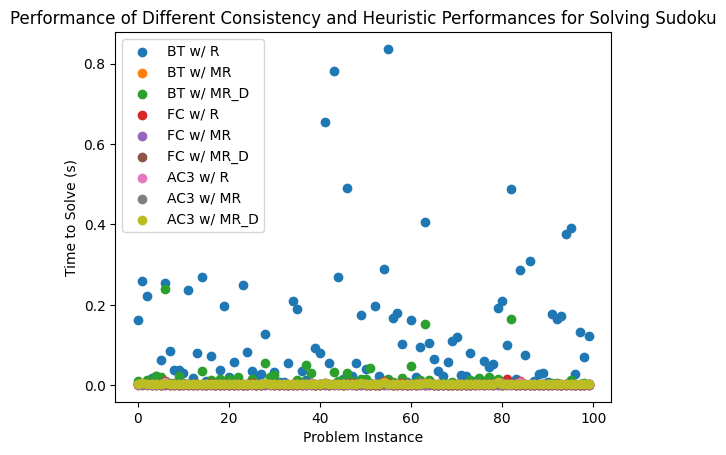

In [11]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Have each combination of consistency and heuristic solve a set number of Sudoku Problem instances 
results = {}
num_problem_instances = 100
cell_length = 3
# I tried making num_missing 50, and it took WAY too long
num_missing = 40 
output_file = "sudoku.json"
for i in range(num_problem_instances):
    write_board(cell_length=cell_length, num_missing=num_missing, output_file=output_file)
    for consistency in Consistency:
        if i == 0:
            results[consistency.value] = {}
        for heuristic in CSPHeuristic:
            start_time = time.time()
            sudoku_solver = SudokuSolver(puzzle_file=output_file,consistency=consistency, heuristic=heuristic)
            sudoku_solver.solve(display_results = False)
            end_time = time.time()
            if i == 0:
                results[consistency.value][heuristic.value] = []
            results[consistency.value][heuristic.value].append(end_time - start_time)
    if i % (num_problem_instances // 10) == 0:
        print(f"{i // (num_problem_instances//10) * 10}% done!")

# Label each type of solver based on its consistency and heuristic, and make a scatter-plot of its results
labels = []
for consistency in Consistency:
    for heuristic in CSPHeuristic:
        labels.append(f"{consistency.name} w/ {heuristic.name}")
        results[consistency.value][heuristic.value] = np.array(results[consistency.value][heuristic.value])
X = np.array(range(num_problem_instances))
current_label_idx = 0
for consistency in Consistency:
    for heuristic in CSPHeuristic:
        Y = results[consistency.value][heuristic.value]
        label = labels[current_label_idx]
        current_label_idx += 1
        plt.scatter(X, Y, label=label)
plt.legend()
plt.title("Performance of Different Consistency and Heuristic Performances for Solving Sudoku")
plt.xlabel("Problem Instance")
plt.ylabel("Time to Solve (s)")
plt.show()

#### Now we will extend the generic CSP solver to the graph coloring problem.

In [12]:
import json
import numpy as np
from typing import Self, Final

class GraphColoringSolver(CSPSolver):
    """
    Solver for Graph Coloring Problem
    """
    # Class constant - it is famously known that an arbitrary map can be colored with four colors
    MIN_NUM_COLORS: Final = 4
    
    def __init__(self, num_colors: int, graph_file: str, consistency: Consistency, heuristic: CSPHeuristic):
        """
        We need the file that contains our connections, we need to know how many colors we are allowed, and we need to know the heuristic and consistency we are using
        """
        super().__init__(consistency=consistency, heuristic=heuristic)
        with open(graph_file, 'r') as f:
            self.__graph_data = json.load(f)
            self.__num_points = self.__graph_data['num_points']
            points = [self.__graph_data['points'][f"\"{i}\""] for i in range(num_points)]
            self.__X = np.array(points[:,0])
            self.__Y = np.array(points[:,1])
            self._graph = CSPGraph(num_assignment_options=max(num_colors, Self.MIN_NUM_COLORS), consistency=self._consistency, consistency_checker=self.__check_available, heuristic=self._heuristic)
        
        # Set up the underlying graph
        for i in range(self.__num_points):
                self._graph.add_node(id=i)
        for connection in self.__graph_data['edges']:
            self._graph.connect(connection[0], connection[1])

    def solve(self, display_results: bool=True):
        """
        Set up the underlying CSPGraph to solve the problem.
        """
        # Call to parent method will make the underlying graph do the solving
        super().solve(display_results=display_results)

        # Now plot if we are supposed to plot
        if display_results:
            labels = []
            for i in range(self.__num_points):
                labels.append(self._graph.get_assignment(id=i))
            plt.scatter(self.__X, self.__Y, labels=labels)
            for connection in self.__graph_data['edges']:
                x1, x2, y1, y2 = self.__X[connection[0]], self.__X[connection[1]], self.__Y[connection[0]], self.__Y[connection[1]]
                plt.plot([x1, x2], [y1, y2], 'bo', linestyle="-")
            plt.show()

    def __check_available(self, first_values: set[int], second_values: set[int]) -> set[int]:
        """
        This is how a GCP Solver determines if any variable options from the second set need to be pruned.
        """
        remove = set() # If the first variable has only ONE option available for it, then the second variable CANNOT have that option in its set of options.
        if len(first_values) == 1:
            first_value = list(first_values)[0]
            if first_value in second_values:
                remove.add(first_value)
        return remove